In [1]:
# In[1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
# from loguru import logger

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# # chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)

chan_enab = [25,26,27,28,29]

# print(os.getcwd())

# os.chdir('E:/LANL/')
# run_num = "12036" 
# datadir = 'sample_data/'
# runs_folder = 'runs12034-12363/'
# uniquefolder = 'debug_sample/'+runs_folder
# folder = uniquefolder
# savefilename = 'SF_Norm_files/'+folder+run_num

os.chdir('F:/LANL/')
run_num = "13617" 
datadir = 'sample_data/'
runs_folder = 'runs13605-13735/'
uniquefolder = 'debug_sample/'+runs_folder
folder = uniquefolder
savefilename = 'SF_Norm_files/'+folder+run_num

# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# savefilename = 'SF_Norm_files/'+uniquefolder+run_num


# if not os.path.exists(os.getcwd() + '/' +'SF_Norm_files/'+uniquefolder):
#     # Create the directory
#     os.makedirs(os.getcwd() + '/' +'SF_Norm_files/'+uniquefolder)
#     print("Directory created successfully!")
# else:
#     pass

# logger.add("F:/LANL/SF_Norm_files/" + uniquefolder + '0_ErrorLog.txt', delay = True)

    # print("Directory already exists!")
# os.mkdir(os.getcwd() + '/' +'SF_Norm_files/'+uniquefolder)

# print('processing data: ' + folder + 'run' + run_num)
# print('processing data: ' + uniquefolder + 'run' + run_num)

# print(os.getcwd() + folder)
statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'

# get_ipython().run_line_magic('matplotlib', 'qt')

start = time.time()
fullstart = time.time()

read_data = []
fileLength = []

#### old one ###
# for el in chan_enab:
#     f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
#     # f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
#     read_data.append(np.fromfile(file=f, dtype=np.uint16))
#     f.close()
#     fileLength.append(len(read_data[-1]))

# fileLength = np.asarray(fileLength)

####### try reading all channels. If no ch 29, try reading ch 25-28. If no 26-28 (coils) try just ch 25. If still an error, log it.
try: ## adding attempt to read La Puck info, Ch. 29
    for el in chan_enab:
        # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
except:
    print('No La Puck state Ch. 29')
    chan_enab = chan_enab[:-1]  ## get rid of ch 29 puck state if there is no ch 29
    try:
        for el in chan_enab:
            # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
            f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
            read_data.append(np.fromfile(file=f, dtype=np.uint16))
            f.close()
            fileLength.append(len(read_data[-1]))
    except: 
        print('Also no coils')
        chan_enab = [chan_enab[0]]  ## get rid of ch 29 puck state if there is no ch 29
        try:
            for el in chan_enab:
                # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
                f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
                read_data.append(np.fromfile(file=f, dtype=np.uint16))
                f.close()
                fileLength.append(len(read_data[-1]))
        except Exception as e:
            print(e)
#             print('run '+run_num + ' failed during data load. Unknown reason')
#             logger.error('run '+run_num + ' failed during data load. Unknown reason')
#             logger.exception(e)

fileLength = np.asarray(fileLength)


# read_data = np.asarray(read_data, dtype = object)  ## cannot do np array for sorting because He and SF are different sizes

print("Channel is " + str(chan_enab))
# print("Run number is " + run_num)
print('saving to state & norm information to ' + savefilename)
end = time.time()
# print(end-start)
# print(read_data)


# Store the big header for each channel in arrays

# In[2]:


BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []

targetDict = {0: "La", 1: "Tb2O3", 2: "Yb2O3", 3: "Sm2O3", 4: "Er2O3", 5: "Ho2O3", 6: "other"}
foilDict = {0: "TBD", 1: "TBD", 2: "TBD", 3: "TBD", 4: "TBD", 5: "TBD", 6: "other"}

target=(read_data[0][5]&0x00F0)>>4
foil=read_data[0][5]&0x000F
targetFlag = read_data[0][5]>>8&1
foilFlag = read_data[0][5]>>9&1
spinFiltFlag = read_data[0][5]>>10&1
spinFlipFlag = read_data[0][5]>>11&1
shutterFlag = read_data[0][5]>>12&1
facilityTrigFlag = read_data[0][5]>>13&1

if targetFlag:
    target=targetDict[(read_data[0][5]&0x00F0)>>4]
    
else:
    target = "empty"
    
if foilFlag:
    foil=foilDict[read_data[0][5]&0x000F]
else:
    foil = "empty"

for i in range(0,len(chan_enab)):
    BoardID.append(read_data[i][9]>>8)
    recordLength.append(((read_data[i][9]&0x00FF)<<16)+read_data[i][8])
    numSamples.append(((read_data[i][11]&0x00FF)<<16)+read_data[i][10])
    eventCounter.append(read_data[i][6]+(read_data[i][7]<<16))
    BoardID.append(read_data[i][9]>>8)  
    decFactor.append(read_data[i][11]>>8)
    chanDec.append(read_data[i][13]>>8)
    postTrig.append(read_data[i][15]>>8)
    groupStart.append(((read_data[i][13]&0x00FF)<<16)+read_data[i][12])
    groupEnd.append(((read_data[i][15]&0x00FF)<<16)+read_data[i][14])
    
    timestamp.append(read_data[i][16]+(read_data[i][17]<<16)+(read_data[i][18]<<32)+(read_data[i][19]<<40))  
    sizeFirstEvent.append(read_data[i][0]+(read_data[i][1]<<16))
    TTT.append(read_data[i][2]+(read_data[i][3]<<16)+(read_data[i][4]<<32))
    
#     print("For channel " + str(chan_enab[i]) + ", BoardID is " + str(BoardID[i])
#           + "; record length is " + str(recordLength[i]) + "; num Samples is " 
#           + str(numSamples[i]) + "; event counter is " + str(eventCounter[i]) + "; dec factor is " + str(decFactor[i]) + "; chan dec is " 
#           + str(chanDec[i]) + "; postTrig is " + str(postTrig[i]) + "; group start is " + str(groupStart[i]) + "; group end is " + str(groupEnd[i])
#           + "; epoch time is " + str(timestamp[i]) +  "; first event size is " + str(sizeFirstEvent[i]) + "; and ETTT is " + str(TTT[i]) + "\n")

numSamples = np.asarray(numSamples)

eventCounter = np.asarray(eventCounter)
TTT = np.asarray(TTT)

print("Target is " + target)
# print("Foil is " + foil)
# print("Shutter is open: " + str(bool(shutterFlag)))
# print("Facility t0 is on: " + str(bool(facilityTrigFlag)))
# print("Spin flipper is on: " + str(bool(spinFlipFlag)))
# print("Spin filter is on: " + str(bool(spinFiltFlag)))
# print("Target is present: " + str(bool(targetFlag)))
# print("Foil is present: " + str(bool(foilFlag)))


# Determine the time axis for each channel

# In[3]:


preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

if chan_enab[0] != 25:
    #print('No 3He. Cannot normalize')
    emessage = ('3He not in first channel loaded. Cannot normalize')
    logger.error(run_num + emessage)
    raise Exception(emessage)
else:
    pass

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr


Channel is [25, 26, 27, 28, 29]
saving to state & norm information to SF_Norm_files/debug_sample/runs13605-13735/13617
Target is empty


In [2]:
start=time.time()


# ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, np.array([25]), fileLength, numSamples) ##hardcoded channel 25 for He
# ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data[1:], np.array([26,27,28]), fileLength[1:], numSamples[1:]) ##hardcoded channels for coils
# ys_arrpuck, ETTT_arrpuck, eventcount_arrpuck  = dataread(read_data[4:], np.array([29]), fileLength[4:], numSamples[4:]) ##hardcoded channels for coils

# print(ETTT_arr)
# ETTT_arr = np.vstack([ETTT_arrHe,ETTT_arr,ETTT_arrpuck]) ## ordering makes sure that first array of new ETTT_arr is ETTT_arr of He
# eventcount_arr = np.vstack([eventcount_arrHe,eventcount_arr,eventcount_arrpuck])

# end = time.time()
# print('dataread from binary time: ' + str(end-start))  

# # Put ADC values in arrays for each channel (one array per event, an array of events per channel) and put the miniheader information in an array

# # Calculate the time difference between each event within a file - used to check for dropping pulses. It seems that if we make the record window 49.152 ms long, we miss every other pulse (at 20 Hz). This is not that surprising - we presumably will not need a lot of data (or any) with the full 50 ms time window.

# timeDif=[]
# for i in range(0,len(chan_enab)):
#     timeDif.append([])
#     for j in range(len(ETTT_arr[i])-1):
#         timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
# #     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
# #     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
# #print(timeDif)

if chan_enab[-1] == 29:
    ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, np.array([25]), fileLength, numSamples) ##hardcoded channel 25 for He
    ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data[1:], np.array([26,27,28]), fileLength[1:], numSamples[1:]) ##hardcoded channels for coils
    ys_arrpuck, ETTT_arrpuck, eventcount_arrpuck  = dataread(read_data[4:], np.array([29]), fileLength[4:], numSamples[4:]) ##hardcoded channel for La Puck
    ETTT_arr = np.vstack([ETTT_arrHe,ETTT_arr,ETTT_arrpuck]) ## ordering makes sure that first array of new ETTT_arr is ETTT_arr of He
    eventcount_arr = np.vstack([eventcount_arrHe,eventcount_arr,eventcount_arrpuck])
elif chan_enab[-1] == 25: ## if no coils and no La Puck
    ys_arrHe, ETTT_arr, eventcount_arr  = dataread(read_data, np.array([25]), fileLength, numSamples) ##hardcoded channel 25 for He
else:
    ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, np.array([25]), fileLength, numSamples) ##hardcoded channel 25 for He
    ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data[1:], np.array([26,27,28]), fileLength[1:], numSamples[1:]) ##hardcoded channels for coils
    ETTT_arr = np.vstack([ETTT_arrHe,ETTT_arr]) ## ordering makes sure that first array of new ETTT_arr is ETTT_arr of He
    eventcount_arr = np.vstack([eventcount_arrHe,eventcount_arr])

end = time.time()
print('dataread from binary time: ' + str(end-start))  

dataread from binary time: 2.2584357261657715


In [3]:
print("Shutter is open: " + str(bool(shutterFlag)))
print(((spinFlipFlag)))

Shutter is open: True
1


[[64999 64999 64999 ... 64999 64999 64999]
 [64999 64999 64999 ... 64999 64999 64999]
 [64999 64999 64999 ... 64999 64999 64999]
 [64999 64999 64999 ... 64999 64999 64999]
 [64999 64999 64999 ... 64999 64999 64999]]
[-1024000.  -958464.  -892928.  -827392.  -761856.  -696320.  -630784.
  -565248.  -499712.  -434176.  -368640.  -303104.  -237568.  -172032.
  -106496.]


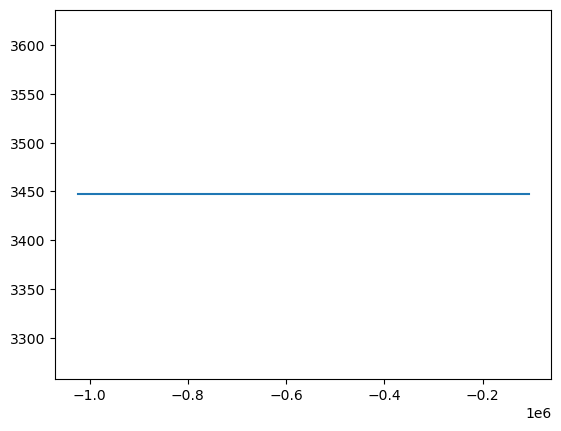

In [4]:
## dont know how to interpret this yet
%matplotlib inline
print(eventcount_arr)
print(xs[4])
plt.plot(xs[4],ys_arrpuck[0][3027])

In [5]:
print(len(ys_arrHe[0][0]))

45000


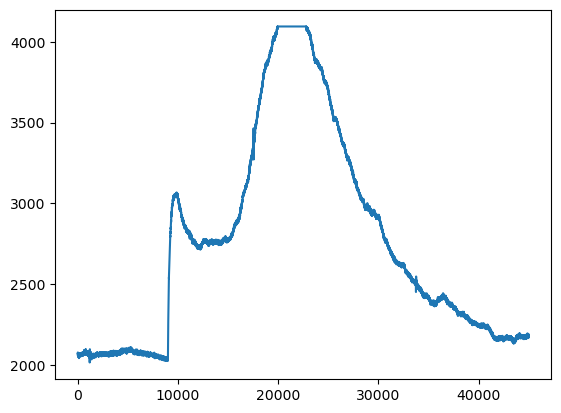

In [6]:
plt.plot(ys_arrHe[0][0])

In [7]:
### old one
# baseL = 0
# baseRCoil = int(((preTime[1]-groupStart[1])*0.70)/chanDec[1])
# baseRHe = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])
# numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)

# if numSamples[0] != 45000:
#     emessage = ('He channel wrong size')
#     logger.error(run_num + ' ' + emessage)
#     raise Exception(emessage)
# elif numSamples[1] != 351:
#     emessage = ('Coil channel wrong size')
#     logger.error(run_num + ' ' + emessage)
#     raise Exception(emessage)
# elif numSamples[2] != 351:
#     emessage = ('Coil channel wrong size')
#     logger.error(run_num + ' ' + emessage)
#     raise Exception(emessage)

baseL = 0
baseRHe = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)

if spinFlipFlag == 0:
    pass
if spinFlipFlag == 1:
    baseRCoil = int(((preTime[1]-groupStart[1])*0.70)/chanDec[1])

if chan_enab[-1] != 25:
    if numSamples[0] != 45000:
        emessage = ('He channel wrong size')
        logger.error(run_num + ' ' + emessage)
        raise Exception(emessage)
    elif numSamples[1] != 351:
        emessage = ('Coil channel wrong size')
        logger.error(run_num + ' ' + emessage)
        raise Exception(emessage)
    elif numSamples[2] != 351:
        emessage = ('Coil channel wrong size')
        logger.error(run_num + ' ' + emessage)
        raise Exception(emessage)
else:
    if numSamples[0] != 45000:
        emessage = ('He channel wrong size')
        logger.error(run_num + ' ' + emessage)
        raise Exception(emessage)

In [58]:
#switchs = [31, 74, 117, 160, 203, 246, 289, 332]
# %matplotlib qt
# %matplotlib inline
    
#legend =  ['He']
legend =  ['LO', 'TR', 'R']
#statesID = ['111', '101', '100', '110','101','110','111','100','111']
transitions = ['111->101', '101->100', '100->110', '110->101','101->110','110->111','111->100','100->111']
switchpulses = np.arange(39,400,45) ##found these pulses which correspond to states 0-8. Change p to plot them
#print(switchpulses)
p=0

# s = switchpulses[p]
s = 110
t=s+7

start = time.time()

## dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        #tempys_basesub = []
        #tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
        #tempsums =[]
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            #ys_basesub.append(ys_arr[i][j] - np.mean(ys_arr[i][j][200:6000]))
            #print(sum(ys_basesub[i][j])) 
#             plt.plot(xs[i], tempys_basesub[i][j] , label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.plot(xs[i], tempys_basesub[i][j])
        if i == 0:
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            plt.axhline(875, ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
#             plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition at ' + str(s)) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
#             plt.legend()
            
# plotter(ys_arrHe, xs, baseRHe,numSamples) ##plot 3He
plotter(ys_arr, xs[1:], baseRCoil, numSamples[1:]) ##plot coils

In [82]:
## these integrals and plots show that the TR coil still recieves (small) signal up to the 4th pulse.

%matplotlib qt
p = 428
c = 1

switchpulses = np.arange(68,450,45)
print(switchpulses)
print(ys_arr[c][1].shape)
# print(ys_arr[2][p])
print(sums[c][p-10:p+10])

s = p+6
for i in range(p,s):
    plt.plot(xs[c],ys_arr[c][i], label = f'pulse {i}')
    
plt.legend()

[ 68 113 158 203 248 293 338 383 428]
(351,)
[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0. -42169.    223.      0.      0.      0.      0.      0.      0.
      0.      0.]


2760.5190444444443


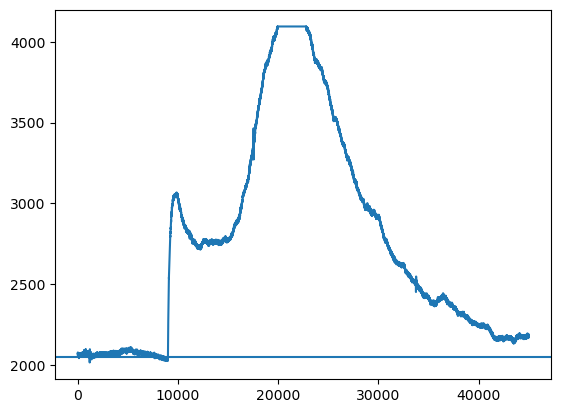

In [9]:
plt.plot(ys_arrHe[0][0])
plt.axhline(y = 2051)
print(np.mean(ys_arrHe[0][0]))

In [10]:
print(numRuns)
print(numSamples)

5000
[45000   351   351   351    15]


In [11]:
#@njit(nopython = True) ## Actually JIT seems to be slower here!
def basesub_sum(ys, baseR, numpoints): ## for coils, could be used for He but below does that
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=np.float64)
    tempsums = np.zeros((len(ys), numRuns), dtype=np.float64)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
            tempsums[i][pulse] = np.sum(tempys_basesub[i][pulse][baseR+5:-1])
    return tempys_basesub, tempsums

if spinFlipFlag == 0:
    print('Spin Flipper is off. No state info.')
    ys_basesub = np.zeros((3,numRuns,351), dtype=np.float64) ##3 channels for what would have been ys_arr. Maybe make this general
    sums = np.zeros((3,numRuns), dtype=np.float64) 
if spinFlipFlag == 1:
    ys_basesub, sums = basesub_sum(ys_arr, baseRCoil, numSamples[1:])

@njit ## separate function for He because this checks every point, can take a while
def basesub_normHe(ys, baseRegion, intgrRegion):
    tempys_basesub = np.zeros((len(ys), numRuns,45000), dtype=np.float64) #hardcode numSamples[0] = 45000
    tempsums = np.zeros((len(ys), numRuns), dtype=np.float64)
    for i in range((len(ys))): ## i is pretty much always 0 for 3He. Left it general.
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            for j in range(intgrRegion[0]+1000, intgrRegion[1]): ## checking for saturation in He channel. restrict to slightly smaller range
                if ys[i][pulse][j] > 4060:  ## cutoff adc value (real is 4092)
                    err = ((('3He is saturating in normalization region at pulse,point: ' + str(pulse) + ', '+ str(j))))
                    print(err)
                else:
                    err = ''
                    pass
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseRegion[0]:baseRegion[1]]))
            tempsums[i][pulse] = np.sum(tempys_basesub[i][pulse][intgrRegion[0]:intgrRegion[1]])
            ## need to investigate adc saturation point
    return tempys_basesub, tempsums, err

baseRHe = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0]) #redefined for clarity

HeBaseReg = np.array([0, baseRHe])
HeIntgrReg = np.array([baseRHe+700, 15999]) ## hardcoded begin/end region for integral over NaI and 6Li regions

if shutterFlag == 0:
    print('Shutter closed. HeNorms set to 1')
    HeNorms = np.ones((1,5000), dtype=np.float64)
if shutterFlag == 1:
    ys_basesubHe, HeNorms, emessage = basesub_normHe(ys_arrHe, HeBaseReg, HeIntgrReg)
## got rid of xs in basesub, don't think we need them as an input 06.10.24

## can't use logger in JIT, so do it outside
# if len(emessage) >1 :
#     logger.error(emessage)
#     raise Exception(emessage)
# else:
#     pass

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            



plotting and/or base subtraction time: 5.616508483886719


In [12]:
print(np.mean(ys_basesubHe[0][0]))
print(HeNorms)

687.4134888888891
[[5128485.10555458 5375942.30555513 5299235.92428559 ... 6091810.06015786
  6554292.06952324 6407941.21587357]]


(array([], dtype=int64), array([], dtype=int64))
0


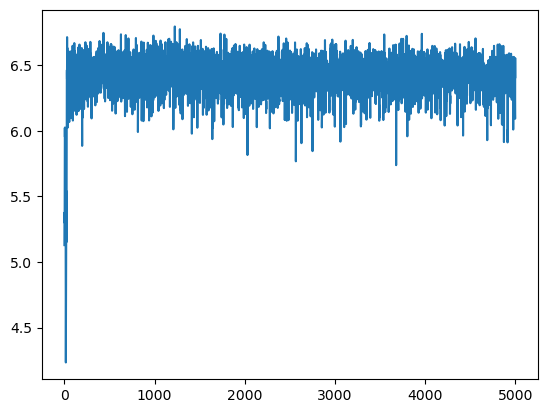

In [13]:
# print(HeNorms/1000000)
print((np.where(HeNorms/1000000<2.0)))
for i in range(len(ys_basesubHe)):
    if np.max(ys_basesubHe[i])<2030:
        print(i)
#     print(np.where(np.max(ys_basesubHe[i])<2030))
plt.plot(HeNorms[0]/1000000)

5000


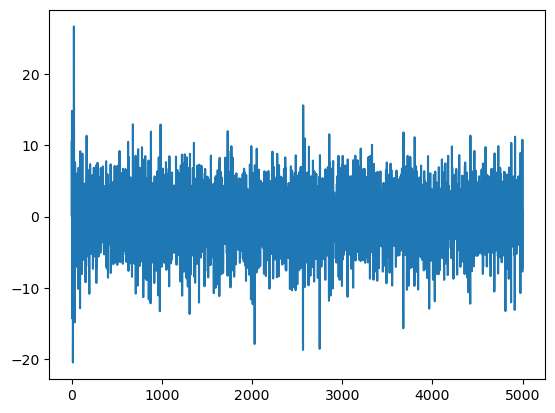

In [14]:
x = HeNorms[0]/1000000

dx = x[1]-x[0]
y = x**2 + 1
dydx = np.gradient(y, dx)
print(len(dydx))
plt.plot(dydx)

5000


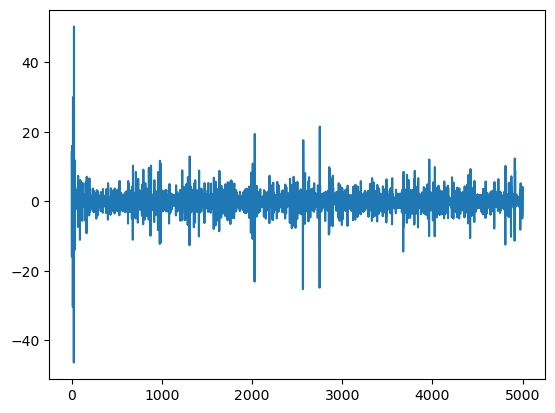

In [15]:
x2 = dydx

dx2 = x2[1]-x2[0]
y2 = x2**2 + 1
dydx2 = np.gradient(y2, dx2)
print(len(dydx2))
plt.plot(dydx2)

In [16]:
start = time.time()

## old one
# statefile = pd.read_csv(statefileloc)
# transitions = statefile['transition'].to_numpy() ## for some reasons "averages" and "std dev" need a space before them
# expectedSumsTR_R = statefile[' averages'].to_numpy()
# expectedStdsTR_R = statefile[' standard dev'].to_numpy()

# AllSwitches = []
# tolerance = 6000 ## see comments below

# ## can't use pre-existing np array because usually one array of unequal length
# for i in range(len(expectedSumsTR_R)):
#     diff_arr = np.absolute(np.add(sums[1],sums[2]) - expectedSumsTR_R[i])
#     found_sums =[]
#     for j in range(len(diff_arr)):
# #         if diff_arr[j] < expectedStdsTR_R[i]*3: ## within 3 standard deviations of its respective std
# ## using std didn't work for La. Maybe just get rid of it and use a constant value...
#         if diff_arr[j] < tolerance: ## this uses a constant "tolerance"
#             found_sums.append(j)
#     AllSwitches.append(np.array(found_sums))

# for i in range(len(AllSwitches)):
#     print(len(AllSwitches[i]))
# end = time.time()
# # print('find switches time: ' + str(end-start)) 

# start = time.time()

statefile = pd.read_csv(statefileloc)
transitions = statefile['transition'].to_numpy() ## for some reasons "averages" and "std dev" need a space before them
expectedSumsTR_R = statefile[' averages'].to_numpy()
expectedStdsTR_R = statefile[' standard dev'].to_numpy()

AllSwitches = []
tolerance = 6000 ## see comments below

if spinFlipFlag == 0:
    pass
if spinFlipFlag == 1:
    ## can't use pre-existing np array because usually one array of unequal length
    for i in range(len(expectedSumsTR_R)):
        diff_arr = np.absolute(np.add(sums[1],sums[2]) - expectedSumsTR_R[i])
        found_sums =[]
        for j in range(len(diff_arr)):
    #         if diff_arr[j] < expectedStdsTR_R[i]*3: ## within 3 standard deviations of its respective std
    ## using std didn't work for La. Maybe just get rid of it and use a constant value...
            if diff_arr[j] < tolerance: ## this uses a constant "tolerance"
                found_sums.append(j)
        AllSwitches.append(np.array(found_sums))

for i in range(len(AllSwitches)):
    print(len(AllSwitches[i]))
end = time.time()
        
end = time.time()
print('find switches time: ' + str(end-start)) 



14
13
14
14
14
14
14
14
find switches time: 0.08979153633117676


In [17]:
print(expectedSumsTR_R)

[ 118730.181 -116769.448  339703.714   65919.2     27057.732 -177115.684
  -66041.496  -26887.357]


In [18]:
## new one WITH IF CLAUSE
## testing sorting with pandas dataframe

if spinFlipFlag == 0:
    #### i.e. no spin flip saving
    print('made bogus df_SF...')
    transitions = ['bogus']
    AllSwitches = ['bogus']
    transitionSumsTR = ['bogus']
    transitionSumsR = ['bogus']
    transitionTR_RAvgs = ['bogus']
    transitionTR_Rstds = ['bogus']
    transitionSumsTR_R = ['bogus']
    cols = ['transition', 'transition_locations', 'sumsTR_R', 'TR_R_avgs', 'TR_R_stds']
    transSumsData = [transitions, AllSwitches, transitionSumsTR_R, transitionTR_RAvgs, transitionTR_Rstds]

    df_SF = pd.DataFrame({cols[0]: transSumsData[0],            
                    cols[1]: transSumsData[1],
                    cols[2]: transSumsData[2],
                    cols[3]: transSumsData[3],
                    cols[4]: transSumsData[4]})
if spinFlipFlag == 1:
    start = time.time()
    transitions = ['111->101', '101->100', '100->110', '110->101','101->110','110->111','111->100','100->111']
    transitionSumsTR = []
    transitionSumsR = []
    transitionTR_RAvgs = []
    transitionTR_Rstds = []
    transitionSumsTR_R = []
    for i in range(0,len(transitions)):
        tempTR = []
        tempR = []
        for j in range(0,len(AllSwitches[i])):
            tempTR.append(sums[1][AllSwitches[i][j]])
            tempR.append(sums[2][AllSwitches[i][j]])
        transitionSumsTR.append(tempTR)
        transitionSumsR.append(tempR)
        transitionSumsTR_R.append(np.add(tempTR,tempR))
        transitionTR_RAvgs.append(np.average(np.add(tempTR,tempR)))
        transitionTR_Rstds.append(np.std(np.add(tempTR,tempR)))

    cols = ['transition', 'transition_locations', 'sumsTR_R', 'TR_R_avgs', 'TR_R_stds']
    transSumsData = [transitions, AllSwitches, transitionSumsTR_R, transitionTR_RAvgs, transitionTR_Rstds]

    df_SF = pd.DataFrame({cols[0]: transSumsData[0],            
                    cols[1]: transSumsData[1],
                    cols[2]: transSumsData[2],
                    cols[3]: transSumsData[3],
                    cols[4]: transSumsData[4]})
    ## 'original dataframe to work with, 7 transitions and their associated locations and sums:

    # with pd.option_context('display.max_rows', None,
    #                       'display.max_columns', None,
    #                       'display.precision', 3,
    #                       ):
    #    print(df_SF.explode(['transition_locations', 'sumsTR_R']))

    ## original dataframe is exploded so that transition_locations and associated sum is unpacked. Indices of state are kept as "nickname" 
    ## save Averages and Stds for future use')

    df_SF = df_SF.explode(['transition_locations', 'sumsTR_R']).reset_index().rename(columns={'index' : 'nicknames'}) #turn the 'index' of the exploded df_SF into a column, then reassign indices

    ## now sort by the transition location and rearrange dataframe indices, only matters for looping (??)
    df_SF = df_SF.sort_values(by=['transition_locations'])
    df_SF = df_SF.reset_index(drop=True)

    for ind in df_SF.index[:-1]:
    #     print('transition: '+ str(df_SF['nicknames'][ind]) + ' location: ' + str(df_SF['transition_locations'][ind]))
        if (df_SF['nicknames'][ind+1])-1 != df_SF['nicknames'][ind]: ## if next transition 'nickname' is not next in sequence, failure
            if (df_SF['nicknames'][ind+1])-1 == -1: ## special condition for end of sequence where (0-1) != 7
                if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) != 45: ## changed to 45 pulses!
                    emessage = '# pulses error: ' + str(df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind])
                    logger.error(run_num + ' ' + emessage)
                    raise Exception(emessage)
                if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) == 45:
                    pass
                    # print('# pulses correct, end of sequence')
            else:
                ## checks that the sequence follows 0-> 1-> 2-> 3... etc order
                emessage = 'sorting failure, ' + str((df_SF['nicknames'][ind+1])-1) + '!=' + str(df_SF['nicknames'][ind])
                logger.error(run_num + ' ' + emessage)
                raise Exception(emessage)
        elif (df_SF['nicknames'][ind+1])-1 == df_SF['nicknames'][ind]:
            if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) != 45: ## error if =/= 45 pulses between each
                emessage = ('# pulses error: ' + str(df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]))
                logger.error(run_num + ' ' + emessage)
                raise Exception(emessage)
            if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) == 45:
                pass
        else:
            emessage = ('Unknown failure in sorting')
            logger.error(run_num + ' ' + emessage)
            raise Exception(emessage)
            
    print('SF # pulses and sequence success')  
    end = time.time()

# print('SF dataframe time: ' + str(end-start))  

SF # pulses and sequence success


In [65]:
# ### old one without if clause

# ## testing sorting with pandas dataframe

# start = time.time()

# transitions = ['111->101', '101->100', '100->110', '110->101','101->110','110->111','111->100','100->111']

# transitionSumsTR = []
# transitionSumsR = []
# transitionTR_RAvgs = []
# transitionTR_Rstds = []
# transitionSumsTR_R = []

# for i in range(0,len(transitions)):
#     tempTR = []
#     tempR = []
#     for j in range(0,len(AllSwitches[i])):
#         tempTR.append(sums[1][AllSwitches[i][j]])
#         tempR.append(sums[2][AllSwitches[i][j]])
#     transitionSumsTR.append(tempTR)
#     transitionSumsR.append(tempR)
#     transitionSumsTR_R.append(np.add(tempTR,tempR))
#     transitionTR_RAvgs.append(np.average(np.add(tempTR,tempR)))
#     transitionTR_Rstds.append(np.std(np.add(tempTR,tempR)))

# cols = ['transition', 'transition_locations', 'sumsTR_R', 'TR_R_avgs', 'TR_R_stds']
# transSumsData = [transitions, AllSwitches, transitionSumsTR_R, transitionTR_RAvgs, transitionTR_Rstds]

# df_SF = pd.DataFrame({cols[0]: transSumsData[0],            
#                    cols[1]: transSumsData[1],
#                    cols[2]: transSumsData[2],
#                    cols[3]: transSumsData[3],
#                    cols[4]: transSumsData[4]})
# ## 'original dataframe to work with, 7 transitions and their associated locations and sums:

# # with pd.option_context('display.max_rows', None,
# #                       'display.max_columns', None,
# #                       'display.precision', 3,
# #                       ):
# #    print(df_SF.explode(['transition_locations', 'sumsTR_R']))

# ## original dataframe is exploded so that transition_locations and associated sum is unpacked. Indices of state are kept as "nickname" 
# ## save Averages and Stds for future use')

# df_SF = df_SF.explode(['transition_locations', 'sumsTR_R']).reset_index().rename(columns={'index' : 'nicknames'}) #turn the 'index' of the exploded df_SF into a column, then reassign indices

# ## now sort by the transition location and rearrange dataframe indices, only matters for looping (??)
# df_SF = df_SF.sort_values(by=['transition_locations'])
# df_SF = df_SF.reset_index(drop=True)

# for ind in df_SF.index[:-1]:
#     print('transition: '+ str(df_SF['nicknames'][ind]) + ' location: ' + str(df_SF['transition_locations'][ind]))
#     if (df_SF['nicknames'][ind+1])-1 != df_SF['nicknames'][ind]: ## if next transition 'nickname' is not next in sequence, failure
#         if (df_SF['nicknames'][ind+1])-1 == -1: ## special condition for end of sequence where (0-1) != 7
#             if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) != 45: ## changed to 45 pulses!
#                 emessage = '# pulses error: ' + str(df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind])
#                 logger.error(run_num + ' ' + emessage)
#                 raise Exception(emessage)
#             if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) == 45:
#                 pass
#                 print('# pulses correct, end of sequence')
#         else:
#             ## checks that the sequence follows 0-> 1-> 2-> 3... etc order
#             emessage = 'sorting failure, ' + str((df_SF['nicknames'][ind+1])-1) + '!=' + str(df_SF['nicknames'][ind])
#             logger.error(run_num + ' ' + emessage)
#             raise Exception(emessage)
#     elif (df_SF['nicknames'][ind+1])-1 == df_SF['nicknames'][ind]:
#         if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) != 45: ## error if =/= 45 pulses between each
#             print(df_SF['transition_locations'][ind])
#             print(df_SF['transition_locations'][ind+1])
#             emessage = ('# pulses error: ' + str(df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) +'. starting at pulse '+
#                         str(df_SF['transition_locations'][ind]))
#             # logger.error(run_num + ' ' + emessage)
#             raise Exception(emessage)
#         if (df_SF['transition_locations'][ind+1]-df_SF['transition_locations'][ind]) == 45:
#             pass
#     else:
#         emessage = ('Unknown failure in sorting')
#         logger.error(run_num + ' ' + emessage)
#         raise Exception(emessage)
        
        
# print('SF # pulses and sequence success')
# end = time.time()

# # print('SF dataframe time: ' + str(end-start))  

In [66]:
print(df_SF[3:15])

    nicknames transition transition_locations       sumsTR_R      TR_R_avgs  \
3           5   110->111                  158 -176982.612245 -177005.488338   
4           6   111->100                  203  -65665.489796  -65681.546647   
5           7   100->111                  248  -27022.081633  -26973.870262   
6           0   111->101                  293  118271.183673  118354.539359   
7           1   101->100                  338 -116310.081633 -116323.832025   
8           2   100->110                  383  339557.959184  339601.712828   
9           3   110->101                  428   65566.795918   65572.610787   
10          4   101->110                  473   27074.918367   27098.051020   
11          5   110->111                  518 -177237.387755 -177005.488338   
12          6   111->100                  563  -65737.183673  -65681.546647   
13          7   100->111                  608  -26977.204082  -26973.870262   
14          0   111->101                  653  11828

In [67]:
print(len(ys_arrpuck))
print(len(ys_arrpuck.tolist()))
print(len(ys_arrpuck.tolist()[0]))
print(len(ys_arrpuck[0]))

print((ys_arrpuck.tolist()))


1
1
5000
5000
[[[2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2043, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2043, 2043, 2043, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2043, 2043, 2043, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2043, 2042, 2042, 2042, 2043, 2043, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2043, 2043, 2043, 2042, 2042, 2042, 2042, 2042], [2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 2042, 204

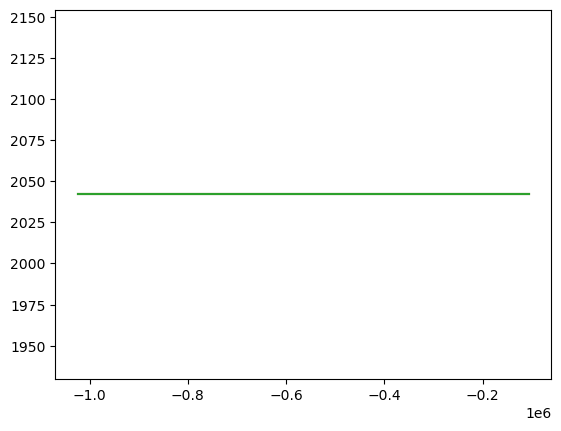

In [68]:
## new LA puck data
## you can use scipy.mode but don't want to import another thing lol
p = 221
plt.plot(xs[4],ys_arrpuck[0][p])
plt.plot(xs[4],ys_arrpuck[0][p+1])
plt.plot(xs[4],ys_arrpuck[0][p+2])

In [69]:
puckstates = []
for i in range(0, len(ys_arrpuck[0])):
    puckval = st.mode(ys_arrpuck[0][i])
    puckstates.append(puckval)
#     if puckval!=2045:
#         plt.plot(xs[4],ys_arrpuck[0][i])
#     print(st.mode(ys_arrpuck[0][i]))
puckstates = np.asarray(puckstates)
print(len(puckstates))
print((puckstates[0]))
# for i in range(0,len(puckstates)):
#     if puckstates[i] != 2045:
#         print(i)

print(max(puckstates), min(puckstates))
# print(np.where(puckstates!=2045))


5000
2042
3476 2030


In [72]:
%matplotlib qt

plt.figure()
plt.plot(puckstates, ls ='-', linewidth = '2.0', label = 'La puck ADC value')
# print(np.round(popt,5))

plt.title(rf'Ch 29 - La Polarization puck values over 5000 pulses', fontsize = 'xx-large')

# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
plt.grid(True, which='both', alpha = 0.5, ls = ':')
plt.minorticks_on()
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')

plt.ylabel('ADC value [arb.]',fontsize = 'x-large')
plt.xlabel('Neutron pulse',fontsize = 'x-large')

plt.legend(loc="upper right", bbox_to_anchor=(1.0, 0.85))
# plt.legend(fontsize = 'medium')
plt.show()


In [71]:
## not sure if mode is the right approach but do it for now
puckstates = []
for i in range(0, len(ys_arrpuck[0])):
    puckval = st.mode(ys_arrpuck[0][i])
    puckstates.append(puckval)           
    print(st.mode(ys_arrpuck[0][i]))
puckstates = np.asarray(puckstates)

print(ys_arrpuck.shape)

2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2048
2040
2042
2043
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2041
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2048
2040
2042
2043
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2030
2043
2044
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042
2042


In [26]:
### saving to a test hdf5

## dataframe for He Norms AND LA PUCK
cols = ['pulse', 'norms','puckval']
pulses = range(numRuns)
normsData = [pulses, HeNorms[0], puckstates]

df_HE = pd.DataFrame({cols[0]: normsData[0],
                      cols[1]: normsData[1],
                      cols[2]: normsData[2]})
#print(df_HE)

# In[10]:

if spinFlipFlag == 0:
    pass
if spinFlipFlag == 1:
    df_SF.to_hdf('test_SF4_saveout' + '.h5', f'df_0', mode='w') ## this "deletes" any previous data in the file name

for idx, df in enumerate([df_SF, df_HE]):
    df.to_hdf('test_SF4_saveout' + '.h5', f'df_{idx}', mode='a') # rerunning this without the above 'w' code will keep increasing file size

# ## end of file creation ##

# In[ ]:

fullend = time.time()
print('full processing time: ' + str(fullend-fullstart)) 
print('\n')

full processing time: 62.89737677574158


